In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import h5py
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [ ]:
train = h5py.File('../rec1501614399_export.hdf5', 'r')
test = h5py.File('../rec1501612590_export.hdf5', 'r')

In [ ]:
window_size = 10

In [ ]:
hidden_size = 50
num_layers = 1
n_heads = 1
d_model = 3 # first a run without any embedding

In [ ]:
class LSTMNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.lstm = nn.LSTM(input_size = 3, hidden_size = hidden_size, num_layers = num_layers)
    self.head = nn.Sequential(
        nn.Linear(hidden_size, 3),
        nn.Sigmoid()
    )

  def forward(self, x):
    x, h = self.lstm(x)
    x = self.head(x[-1])
    return x

In [ ]:
class TransNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.TransformerEncoderLayer(d_model =d_model, nhead=n_heads, dim_feedforward=300)
    self.head = nn.Sequential(
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.encoder(x)
    x = self.head(x[-1])
    return x

In [ ]:
lstmNet = LSTMNet()
transNet = TransNet()
lstmNet.to(device)
transNet.to(device)

TransNet(
  (encoder): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=3, out_features=3, bias=True)
    )
    (linear1): Linear(in_features=3, out_features=300, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=300, out_features=3, bias=True)
    (norm1): LayerNorm((3,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((3,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (head): Sequential(
    (0): Sigmoid()
  )
)

## LSTM

In [ ]:
criterion = nn.L1Loss()
optimizer = optim.SGD(lstmNet.parameters(), lr=0.01)

In [ ]:
%%time

sensors_queue = []
num_epochs = 1
losses= []
for epoch in range(num_epochs):
    for i in range(len(train["accelerator_pedal_position"])):

        sensors = [train['accelerator_pedal_position'][i]/100,
                  train['brake_pedal_status'][i],
                  (train['steering_wheel_angle'][i]+600)/1200]

        if ((len(sensors_queue) < window_size)):
          sensors_queue.append(sensors)
          continue
        else:
          sensors_queue.pop(0)
          sensors_queue.append(sensors)

        if((len(sensors_queue) != window_size)):
          print(len(sensors_queue))
          break

        sensors_queue_tensor = torch.tensor(sensors_queue, dtype=torch.float32).to(device)

        output = lstmNet(sensors_queue_tensor[:-1])
        optimizer.zero_grad()
        loss = criterion(output, sensors_queue_tensor[-1])

        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    print(f"done epoch {epoch}")

done epoch 0
CPU times: user 22.7 s, sys: 235 ms, total: 22.9 s
Wall time: 25.8 s


0.12999702396271492


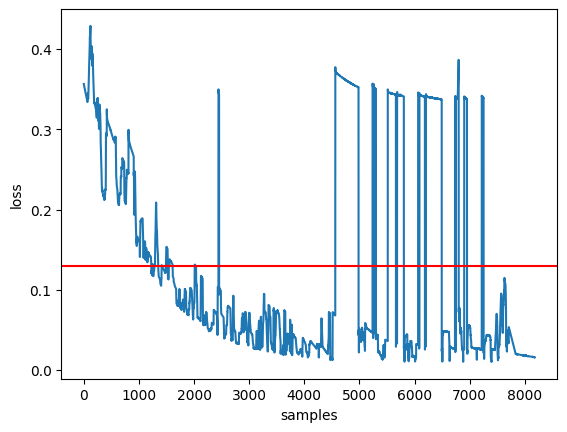

In [ ]:
print(np.mean(losses))
plt.plot(losses)
plt.axhline(np.mean(losses), color='r')
plt.xlabel("samples")
plt.ylabel("loss")
plt.show()

In [ ]:
%%time

img_queue = []
sensors_queue = []
predictions_lstm = []
losses= []
lstmNet.eval()
with torch.no_grad():
    for i in range(len(test["accelerator_pedal_position"])):

        sensors = [test['accelerator_pedal_position'][i]/100,
                  test['brake_pedal_status'][i],
                  (test['steering_wheel_angle'][i]+600)/1200]

        if ((len(sensors_queue) < window_size)):
          sensors_queue.append(sensors)
          continue
        else:
          sensors_queue.pop(0)
          sensors_queue.append(sensors)

        if((len(sensors_queue) != window_size)):
          print(len(sensors_queue))
          break

        sensors_queue_tensor = torch.tensor(sensors_queue, dtype=torch.float32).to(device)

        output = lstmNet(sensors_queue_tensor[:-1])

        loss = criterion(output, sensors_queue_tensor[-1])
        losses.append(loss.item())
        predictions_lstm.append(output.tolist())

        if (i % 1000) == 0:
            print(f"{i}")

1000
2000
3000
4000
5000
6000
7000
8000
CPU times: user 11.6 s, sys: 168 ms, total: 11.8 s
Wall time: 13.8 s


0.11542031553185078


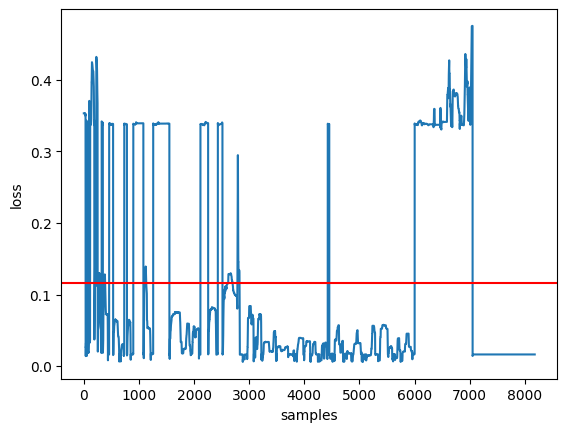

In [ ]:
print(np.mean(losses))
plt.plot(losses)
plt.axhline(np.mean(losses), color='r')
plt.xlabel("samples")
plt.ylabel("loss")
plt.show()

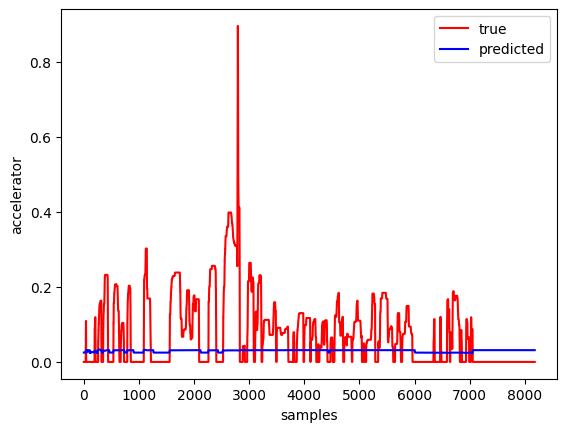

In [ ]:
accelerations = [element[0] for element in predictions_lstm]
truth = test['accelerator_pedal_position'][window_size:].tolist()
truth = [x / 100 for x in truth]
accelerations = [x for x in accelerations]
plt.plot(truth, color='r', label='true')
plt.plot(accelerations, color='b', label='predicted')
plt.xlabel('samples')
plt.ylabel('accelerator')
plt.legend()
plt.savefig('acc_lstm.png')
plt.show()

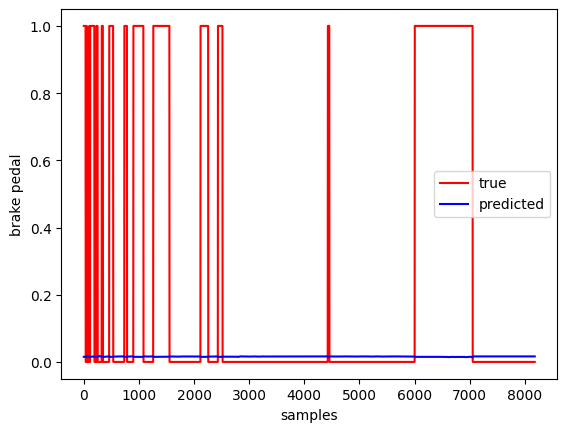

In [ ]:
brakes = [element[1] for element in predictions_lstm]
truth = test['brake_pedal_status'][window_size:].tolist()
plt.plot(truth, color='r', label='true')
plt.plot(brakes, color='b', label='predicted')
plt.xlabel('samples')
plt.ylabel('brake pedal')
plt.legend()
plt.savefig('brk_lstm.png')
plt.show()

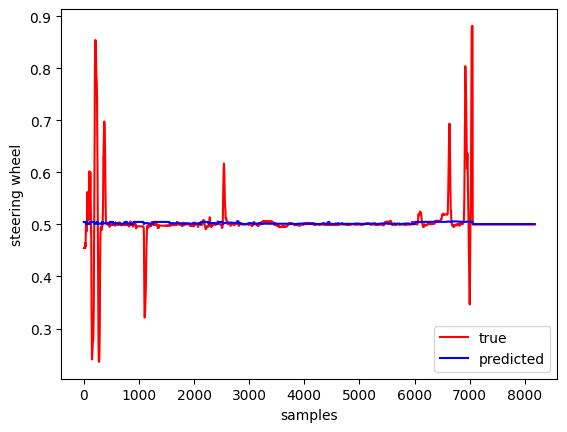

In [ ]:
steers = [element[2] for element in predictions_lstm]
truth = test['steering_wheel_angle'][window_size:].tolist()
truth = [(x + 600) / 1200 for x in truth]
steers = [x for x in steers]
plt.plot(truth[:], color='r', label='true')
plt.plot(steers[:], color='b', label='predicted')
plt.xlabel('samples')
plt.ylabel('steering wheel')
plt.legend()
plt.savefig('str_lstm.png')
plt.show()

## Transformer

In [ ]:
criterion = nn.L1Loss()
optimizer = optim.SGD(transNet.parameters(), lr=0.01)

In [ ]:
%%time

sensors_queue = []
num_epochs = 1
losses= []
for epoch in range(num_epochs):
    for i in range(len(train["accelerator_pedal_position"])):

        sensors = [train['accelerator_pedal_position'][i]/100,
                  train['brake_pedal_status'][i],
                  (train['steering_wheel_angle'][i]+600)/1200]

        if ((len(sensors_queue) < window_size)):
          sensors_queue.append(sensors)
          continue
        else:
          sensors_queue.pop(0)
          sensors_queue.append(sensors)

        if((len(sensors_queue) != window_size)):
          print(len(sensors_queue))
          break

        sensors_queue_tensor = torch.tensor(sensors_queue, dtype=torch.float32).to(device)

        output = transNet(sensors_queue_tensor[:-1])
        optimizer.zero_grad()
        loss = criterion(output, sensors_queue_tensor[-1])

        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print(f"done epoch {epoch}")

done epoch 0
CPU times: user 28.3 s, sys: 178 ms, total: 28.5 s
Wall time: 29 s


0.05487205981528712


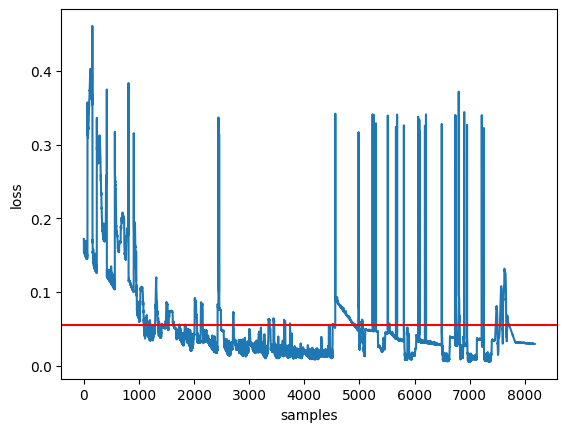

In [ ]:
print(np.mean(losses))
plt.plot(losses)
plt.axhline(np.mean(losses), color='r')
plt.xlabel("samples")
plt.ylabel("loss")
plt.show()

In [ ]:
%%time

img_queue = []
sensors_queue = []
predictions_trans = []
num_epochs = 1
losses= []
transNet.eval()
with torch.no_grad():
    for i in range(len(test["accelerator_pedal_position"])):

        sensors = [test['accelerator_pedal_position'][i]/100,
                  test['brake_pedal_status'][i],
                  (test['steering_wheel_angle'][i]+600)/1200]

        if ((len(sensors_queue) < window_size)):
          sensors_queue.append(sensors)
          continue
        else:
          sensors_queue.pop(0)
          sensors_queue.append(sensors)

        if((len(sensors_queue) != window_size)):
          print(len(sensors_queue))
          break

        sensors_queue_tensor = torch.tensor(sensors_queue, dtype=torch.float32).to(device)

        output = transNet(sensors_queue_tensor[:-1])

        loss = criterion(output, sensors_queue_tensor[-1])
        losses.append(loss.item())
        predictions_trans.append(output.tolist())

        if (i % 1000) == 0:
            print(f"{i}")

1000
2000
3000
4000
5000
6000
7000
8000
CPU times: user 11.8 s, sys: 130 ms, total: 12 s
Wall time: 12.1 s


0.03236386916661406


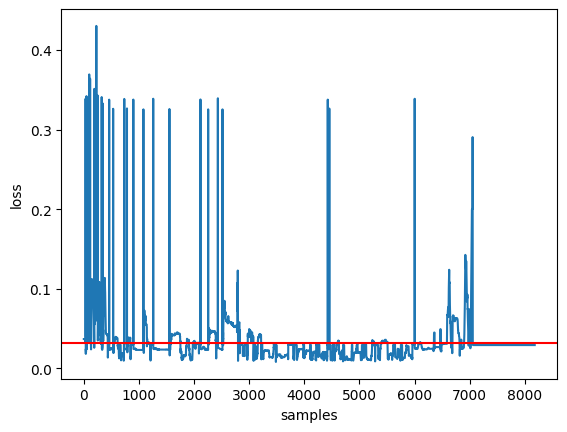

In [ ]:
print(np.mean(losses))
plt.plot(losses)
plt.axhline(np.mean(losses), color='r')
plt.xlabel("samples")
plt.ylabel("loss")
plt.show()

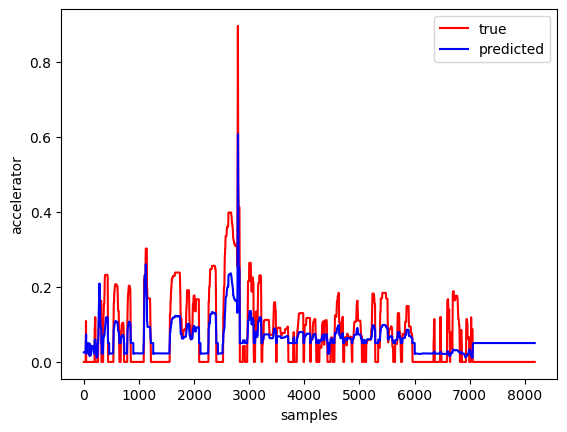

In [ ]:
accelerations = [element[0] for element in predictions_trans]
truth = test['accelerator_pedal_position'][window_size:].tolist()
truth = [x / 100 for x in truth]
accelerations = [x for x in accelerations]
plt.plot(truth, color='r', label='true')
plt.plot(accelerations, color='b', label='predicted')
plt.xlabel('samples')
plt.ylabel('accelerator')
plt.legend()
plt.savefig('acc_trans.png')
plt.show()

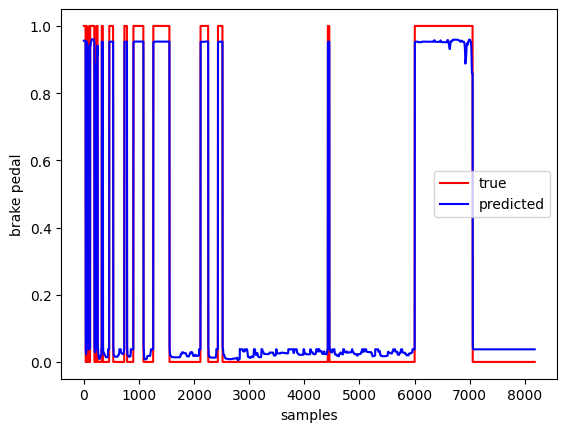

In [ ]:
brakes = [element[1] for element in predictions_trans]
truth = test['brake_pedal_status'][window_size:].tolist()
plt.plot(truth, color='r', label='true')
plt.plot(brakes, color='b', label='predicted')
plt.xlabel('samples')
plt.ylabel('brake pedal')
plt.legend()
plt.savefig('brk_trans.png')
plt.show()

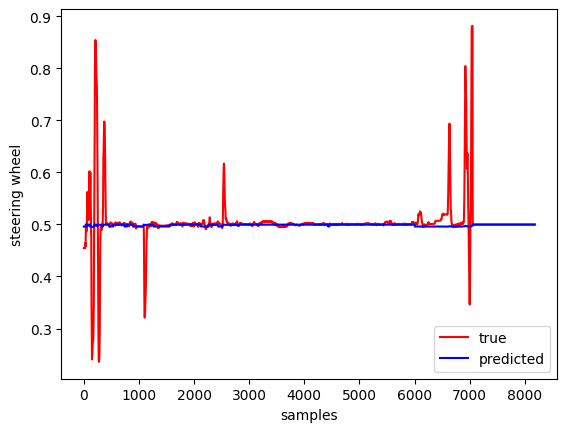

In [ ]:
steers = [element[2] for element in predictions_trans]
truth = test['steering_wheel_angle'][window_size:].tolist()
truth = [(x + 600) / 1200 for x in truth]
steers = [x for x in steers]
plt.plot(truth[:], color='r', label='true')
plt.plot(steers[:], color='b', label='predicted')
plt.xlabel('samples')
plt.ylabel('steering wheel')
plt.legend()
plt.savefig('str_trans.png')
plt.show()

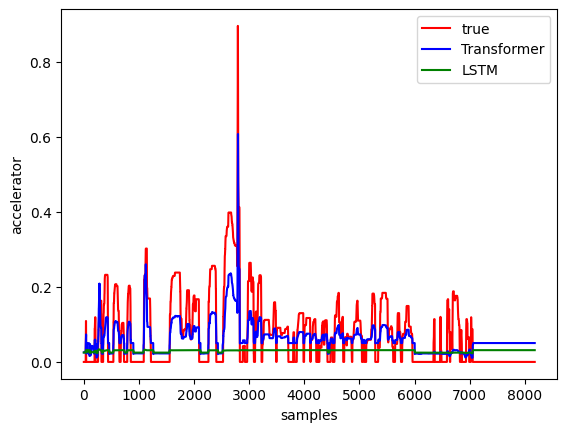

In [ ]:
accelerations_trans = [element[0] for element in predictions_trans]
accelerations_lstm = [element[0] for element in predictions_lstm]

truth = test['accelerator_pedal_position'][window_size:].tolist()
truth = [x / 100 for x in truth]
plt.plot(truth, color='r', label='true')
plt.plot(accelerations_trans, color='b', label='Transformer')
plt.plot(accelerations_lstm, color='g', label='LSTM')
plt.xlabel('samples')
plt.ylabel('accelerator')
plt.legend()
plt.savefig('acc_compared.png')
plt.show()

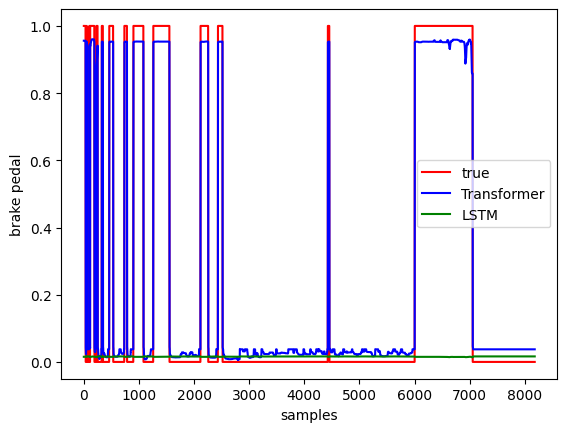

In [ ]:
brakes_trans = [element[1] for element in predictions_trans]
brakes_lstm = [element[1] for element in predictions_lstm]
truth = test['brake_pedal_status'][window_size:].tolist()
plt.plot(truth, color='r', label='true')
plt.plot(brakes_trans, color='b', label='Transformer')
plt.plot(brakes_lstm, color='g', label='LSTM')
plt.xlabel('samples')
plt.ylabel('brake pedal')
plt.legend()
plt.savefig('brk_compared.png')
plt.show()

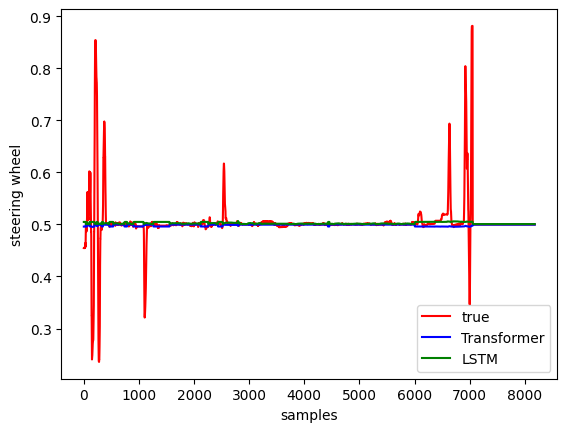

In [ ]:
steers_trans = [element[2] for element in predictions_trans]
steers_lstm = [element[2] for element in predictions_lstm]
truth = test['steering_wheel_angle'][window_size:].tolist()
truth = [(x + 600) / 1200 for x in truth]
plt.plot(truth[:], color='r', label='true')
plt.plot(steers_trans, color='b', label='Transformer')
plt.plot(steers_lstm, color='g', label='LSTM')
plt.xlabel('samples')
plt.ylabel('steering wheel')
plt.legend()
plt.savefig('str_compared.png')
plt.show()

In [ ]:
predictions_lstm_tensor = torch.tensor(predictions_lstm, dtype=torch.float32).to(device)
predictions_trans_tensor = torch.tensor(predictions_trans, dtype=torch.float32).to(device)
torch.save(predictions_lstm_tensor, './predictions_lstm.pt')
torch.save(predictions_trans_tensor, './predictions_trans.pt')